Rather than bootstrapping for eps, use MC methods

In [62]:
import gym
import numpy as np
import pandas as pd
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
import Box2D
env = gym.make('Blackjack-v0')#.env
rand_pol = np.random.randint(0,6,1000)
obs= env.reset()
#env.render()

Blackjack rules and scoring:
    - first to make 21
    - Reward for stick:
        - +1 if sum of cards > sum of dealer cards 0 if sum of cards = sum of dealer cards -1 if sum of cards < sum of dealer cards
        - Reward for twist:
        - -1 if sum of cards > 21 (and terminate)
        - 0 otherwise

In [3]:
print(env.action_space)
print(env.observation_space)

Discrete(2)
Tuple(Discrete(32), Discrete(11), Discrete(2))


In [4]:
def policy(score):
    if score <=12:
        return 1
    elif score >=20:
        return 0
    else:
        r = np.random.randint(1,10)
        if r<=5:
            return 0
        else:
            return 1

def every_visit_mc(env, n_eps=1000000):
    all_visits={}
    count_visits={}
    returns ={}
    
    #generate episode 
    for ep in range(n_eps):
        list_s=[]
        
        ep_visits={}
        ep_counts = {}
        ep_returns = {}
        
        observation =env.reset()
        
        for t in range(100000):
            
            score, dealer_score, ace = observation
            action = policy(score)
            next_state, rew, done, info = env.step(action)
            list_s.append([observation, action, rew])
            if done:
                break
            observation=next_state
                
        for (observation, action, rew) in list_s:
            if not (observation,action) in ep_visits.keys():
                if (observation[0]==20 or observation[0]==21) and rew==0.0:
                    continue
                else:
                    ep_visits[(observation, action)]=float(rew)
                    ep_counts[(observation, action)]=1.0
                    all_visits[(observation, action)]=float(rew)
                    count_visits[(observation, action)]=1.0
            else:
                ep_visits[(observation, action)]+=float(rew)
                ep_counts[(observation, action)]+=1.0
                count_visits[(observation, action)]+=1.0
                all_visits[(observation, action)]+=float(rew)
       
        for ((observation, action),rew) in ep_visits.items():
            ep_returns[(observation, action)]=ep_visits[(observation, action)]/ep_counts[(observation,action)]
        #print('Returns for this episode: %s \n'%ep_returns)

    #Take the average across all episodes 
    for ((observation, action), rew) in all_visits.items():
        returns[(observation, action)]=all_visits[(observation, action)]/count_visits[(observation, action)]
    #print('Final avg returns: %s \n'%returns)
        
    return returns
    
V = every_visit_mc(env)

#print(pd.DataFrame.from_dict(sorted(V.items(), key= lambda x:x)))

In [5]:
V

{((4, 1, False), 1): 0.0,
 ((4, 2, False), 1): 0.0,
 ((4, 3, False), 1): 0.0,
 ((4, 4, False), 1): 0.0,
 ((4, 5, False), 1): 0.0,
 ((4, 6, False), 1): 0.0,
 ((4, 7, False), 1): 0.0,
 ((4, 8, False), 1): 0.0,
 ((4, 9, False), 1): 0.0,
 ((4, 10, False), 1): 0.0,
 ((5, 1, False), 1): 0.0,
 ((5, 2, False), 1): 0.0,
 ((5, 3, False), 1): 0.0,
 ((5, 4, False), 1): 0.0,
 ((5, 5, False), 1): 0.0,
 ((5, 6, False), 1): 0.0,
 ((5, 7, False), 1): 0.0,
 ((5, 8, False), 1): 0.0,
 ((5, 9, False), 1): 0.0,
 ((5, 10, False), 1): 0.0,
 ((6, 1, False), 1): 0.0,
 ((6, 2, False), 1): 0.0,
 ((6, 3, False), 1): 0.0,
 ((6, 4, False), 1): 0.0,
 ((6, 5, False), 1): 0.0,
 ((6, 6, False), 1): 0.0,
 ((6, 7, False), 1): 0.0,
 ((6, 8, False), 1): 0.0,
 ((6, 9, False), 1): 0.0,
 ((6, 10, False), 1): 0.0,
 ((7, 1, False), 1): 0.0,
 ((7, 2, False), 1): 0.0,
 ((7, 3, False), 1): 0.0,
 ((7, 4, False), 1): 0.0,
 ((7, 5, False), 1): 0.0,
 ((7, 6, False), 1): 0.0,
 ((7, 7, False), 1): 0.0,
 ((7, 8, False), 1): 0.0,
 ((7, 9, 

In [65]:
rewards = [val for val in V.values()]
scores = [obs[0] for(obs, act) in V.keys()]
actions = [act for(obs, act) in V.keys()]

<function matplotlib.pyplot.show>

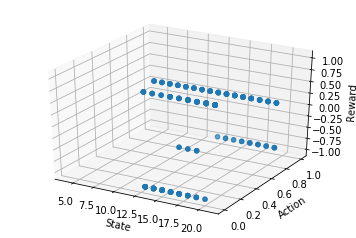

In [75]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(scores, actions, rewards)
ax.set_xlabel('State')
ax.set_ylabel('Action')
ax.set_zlabel('Reward')
plt.show